In [261]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
# %pip install xgboost
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance
import os
import shutil
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

Defining the features

In [262]:
data = pd.read_csv('data.csv')

X_questions = data.iloc[:, 2:182]
X_questions = X_questions.drop('date_visit', axis=1) # Data não é relevante
X_questions = X_questions.drop(X_questions.columns[[46, 133, 158, 161]], axis=1) # Essas colunas são constantes

X_drugs = data.iloc[:, 185:]
X_drugs = X_drugs.drop(X_drugs.columns[[50,51,61,92,101,111,114,121,137,140,141,142,143,148,151,152]], axis=1) # Essas colunas são constantes

X_random = np.random.rand(X_questions.shape[0], 1)

X = np.concatenate((X_questions, X_drugs), axis=1)
X = pd.DataFrame(X)

# print(X_questions.iloc[:2, 3:4])
# print(X_questions.iloc[:2, 4:5])
# print(X_questions.iloc[:2, 79:80])
print(X_questions.shape)
print(X_drugs.shape)
print(X.shape)

(625, 175)
(625, 137)
(625, 312)


Defining the target

In [263]:
Y = data.iloc[:, 182:185]

y_vas30 = Y.iloc[:, 0:1].values.ravel()
y_vas50 = Y.iloc[:, 1:2].values.ravel()
y_gic = Y.iloc[:, 2:3].values.ravel()

y_perceived = np.logical_or(y_vas30, y_vas50) # Perceived improvement by the patient is defined as either VAS30 or VAS50
y_perceived = y_perceived.astype(int)

# The target is defined as the intersection of perceived improvement and GIC,
# this is because the patient must perceive improvement and the doctor must agree
y = np.logical_and(y_perceived, y_gic)
y = y.astype(int)
y = pd.DataFrame(y)

# Find the indices of the rows with all 0's
zero_rows = y.index[(y == 0).all(axis=1)]
# Randomly select 50% of these indices
delete_rows = np.random.choice(zero_rows, size=int(len(zero_rows)/1.2), replace=False)

# Drop the selected rows
X = X.drop(delete_rows)
X_drugs = X_drugs.drop(delete_rows)
X_questions = X_questions.drop(delete_rows)
X_random = np.delete(X_random, delete_rows, axis=0)

y = np.delete(y, delete_rows)
y_gic = np.delete(y_gic, delete_rows)
y_vas30 = np.delete(y_vas30, delete_rows)
y_vas50 = np.delete(y_vas50, delete_rows)
y_perceived = np.delete(y_perceived, delete_rows)

print(X_questions.shape)
print(X_drugs.shape)
print(X.shape)
print(y.shape)

print(f"The percentage of ones inside y_gic is {(np.sum(y_gic)/y_gic.shape[0])*100:.2f}%")
print(f"The percentage of ones inside y_vas30 is {(np.sum(y_vas30)/y_vas30.shape[0])*100:.2f}%")
print(f"The percentage of ones inside y_vas50 is {(np.sum(y_vas50)/y_vas50.shape[0])*100:.2f}%")
print()
print(f"The percentage of ones inside y_perceived is {(np.sum(y_perceived)/y_perceived.shape[0])*100:.2f}%")
print(f"The percentage of ones inside y is {(np.sum(y)/y.shape[0])*100:.2f}%")
# Faz sentido a porcentagem de 1's ser baixa em y, pois como dito em nossa reunião a maior parte
# dos pacientes que sofrem com dor crônica não apresentam melhora.


(183, 175)
(183, 137)
(183, 312)
(183,)
The percentage of ones inside y_gic is 57.92%
The percentage of ones inside y_vas30 is 67.21%
The percentage of ones inside y_vas50 is 56.83%

The percentage of ones inside y_perceived is 67.21%
The percentage of ones inside y is 51.37%


In [264]:
similarity_vas50 = accuracy_score(y_gic, y_vas50) # y_gic is 'true', how similar is y_vas50 to it?
similarity_vas50 *= 100
print(f"The similarity percentage between y_gic and y_vas50 is {similarity_vas50:.2f}%")

similarity_vas30 = accuracy_score(y_gic, y_vas30) # y_gic is 'true', how similar is y_vas30 to it?
similarity_vas30 *= 100
print(f"The similarity percentage between y_gic and y_vas30 is {similarity_vas30:.2f}%")

similarity_perceived = accuracy_score(y_gic, y_perceived) # y_gic is 'true', how similar is y_perceived to it?
similarity_perceived *= 100
print(f"The similarity percentage between y_gic and y_perceived is {similarity_perceived:.2f}%")

The similarity percentage between y_gic and y_vas50 is 70.49%
The similarity percentage between y_gic and y_vas30 is 77.60%
The similarity percentage between y_gic and y_perceived is 77.60%


In [265]:
similarity_gic = accuracy_score(y, y_gic) # y is 'true', how similar is y_gic to it?
similarity_gic *= 100
print(f"The similarity percentage between y and y_gic is {similarity_gic:.2f}%")

similarity_vas50 = accuracy_score(y, y_vas50) # y is 'true', how similar is y_vas50 to it?
similarity_vas50 *= 100
print(f"The similarity percentage between y and y_vas50 is {similarity_vas50:.2f}%")

similarity_vas30 = accuracy_score(y, y_vas30) # y is 'true', how similar is y_vas30 to it?
similarity_vas30 *= 100
print(f"The similarity percentage between y and y_vas30 is {similarity_vas30:.2f}%")

similarity_perceived = accuracy_score(y, y_perceived) # y is 'true', how similar is y_perceived to it?
similarity_perceived *= 100
print(f"The similarity percentage between y and y_perceived is {similarity_perceived:.2f}%")

The similarity percentage between y and y_gic is 93.44%
The similarity percentage between y and y_vas50 is 77.05%
The similarity percentage between y and y_vas30 is 84.15%
The similarity percentage between y and y_perceived is 84.15%


Encoding the Boolean variables

In [266]:
le = LabelEncoder()
for col in X_questions.columns:
    if X_questions[col].dtype == 'bool':
        X_questions[col] = le.fit_transform(X_questions[col])

for col in X_drugs.columns:
    if X_drugs[col].dtype == 'bool':
        X_drugs[col] = le.fit_transform(X_drugs[col])

for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = le.fit_transform(X[col])

Imputing missing values

In [267]:
imp = SimpleImputer(strategy='mean')
imp.fit(X_questions)
X_questions = imp.transform(X_questions)

imp = SimpleImputer(strategy='mean')
imp.fit(X_drugs)
X_drugs = imp.transform(X_drugs)

imp = SimpleImputer(strategy='mean')
imp.fit(X)
X = imp.transform(X)

Normalizing features

In [268]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_drugs = scaler.fit_transform(X_drugs)
X_questions = scaler.fit_transform(X_questions)
X_random = scaler.fit_transform(X_random)

In [270]:
def trainClassifier(X, y, clf, print_accuracy=False):
    kf = KFold(n_splits=5)
    empirical_losses = []
    test_losses = []
    empirical_accuracies = []
    test_accuracies = []

    for train_indices, test_indicies in kf.split(X):
        X_train, X_test = X[train_indices], X[test_indicies]
        y_train, y_test = y[train_indices], y[test_indicies]
        
        clf.fit(X_train, y_train) # classificador generico

        empirical_loss = log_loss(y_train, clf.predict(X_train))
        test_loss = log_loss(y_test, clf.predict(X_test))

        empirical_accuracy = clf.score(X_train, y_train)
        test_accuracy = clf.score(X_test, y_test)

        empirical_losses.append(empirical_loss)
        test_losses.append(test_loss)

        empirical_accuracies.append(empirical_accuracy)
        test_accuracies.append(test_accuracy)

    empirical_loss = np.mean(empirical_losses)
    test_loss = np.mean(test_losses)

    empirical_accuracy = np.mean(empirical_accuracies) * 100
    test_accuracy = np.mean(test_accuracies) * 100

    if print_accuracy:
        print(f"empirical_accuracy: {empirical_accuracy: .2f}% | test_accuracy: {test_accuracy: .2f}% ")

    return (empirical_loss, test_loss)

def trainXGBBoostingClassifier(X, y, max_depth=0, gamma=0.0, print_accuracy=False, print_importance=False):
    clf = xgb.XGBClassifier(max_depth=max_depth,  gamma=gamma, eta=0.01, min_child_weight=1, subsample=0.8, 
                            colsample_bytree=0.8, scale_pos_weight=1)
    
    if print_importance:
        clf.fit(X, y)
        feat_imp = pd.Series(clf.get_booster().get_fscore())
        feat_imp.index = pd.Index(feat_imp.index)
        feat_imp.sort_values(ascending=False, inplace=True)
        feat_imp.plot(kind='bar', title='Feature Importances', width=0.8, figsize=(20,10))
        plt.ylabel('Feature Importance Score')
        
    return trainClassifier(X, y, clf, print_accuracy)

def trainMLPClassifier(X, y, hidden_layer_size=0, print_accuracy=False):
    clf = MLPClassifier(hidden_layer_sizes=(hidden_layer_size,), solver='sgd', learning_rate_init=0.01,
                        max_iter=2000, verbose=False)
    return trainClassifier(X, y, clf, print_accuracy)

def trainRandomForestClassifier(X, y, max_depth=0, print_accuracy=False):
    clf =clf = RandomForestClassifier(n_estimators=1000, max_depth=max_depth)
    return trainClassifier(X, y, clf, print_accuracy)

In [247]:
def createPlotDir(alg_name):
    if not os.path.exists(f"plots"):
        os.mkdir(f"plots")

    if not os.path.exists(f"plots/{alg_name}"):
        os.mkdir(f"plots/{alg_name}/")

def savePlot(data, alg_name, filename):
    x = sorted(data.keys())
    empirical_losses = [data[key][0] for key in x]
    test_losses = [data[key][1] for key in x]

    legend = ['test loss', 'empirical loss']
    plt.ylim((0,30))
    plt.grid()
    plt.plot(x, test_losses, color='blue', linestyle='dashed')
    plt.plot(x, empirical_losses, color='blue')
    plt.legend(legend)

    plt.savefig(f'plots/{alg_name}/{filename}.png')
    plt.clf() 

In [147]:
def plotCapacityGraphsForMLP(X, y, filename, max_neuron_nb):
    createPlotDir('mlp')

    data = dict()
    for neuron_nb in range(1, max_neuron_nb+1, 10):
        print(f"{(neuron_nb/max_neuron_nb)*100:.2f}%...", end="\r")
        (empirical_loss, test_loss) = trainMLPClassifier(X, y, hidden_layer_size=neuron_nb)
        data[neuron_nb] = (empirical_loss, test_loss)
   
    savePlot(data, 'mlp', filename)

max_neuron_nb = 200
plotCapacityGraphsForMLP(X, y, "x", max_neuron_nb)
plotCapacityGraphsForMLP(X_questions, y, "x_questions", max_neuron_nb)
plotCapacityGraphsForMLP(X_drugs, y, "x_drugs", max_neuron_nb)
plotCapacityGraphsForMLP(X_random, y, "x_random", max_neuron_nb)

<Figure size 640x480 with 0 Axes>

In [146]:
def plotCapacityGraphsForXGBoost(X, y, filename, max_depth, print_accuracy=False):
    gamma = 0
    createPlotDir('xgboost')

    data = dict()
    for depth in range(1, max_depth+1):
        print(f"{(depth/max_depth)*100:.2f}%...", end="\r")
        (empirical_loss, test_loss) = trainXGBBoostingClassifier(X, y, max_depth=depth, gamma=gamma, print_accuracy=print_accuracy)
        data[depth] = (empirical_loss, test_loss)
   
    savePlot(data, 'xgboost', filename)

max_depth = 10
plotCapacityGraphsForXGBoost(X, y, "x", max_depth) # Adicionar X_drugs parece não ter efeito
plotCapacityGraphsForXGBoost(X_questions, y, "x_questions", max_depth, print_accuracy=False) # Resultado diferente do aleatorio mas ainda sim
plotCapacityGraphsForXGBoost(X_drugs, y_gic, "x_drugs", max_depth) # X_drugs parece ter nenhum poder preditivo
plotCapacityGraphsForXGBoost(X_random, y, "x_random", max_depth, print_accuracy=False)

<Figure size 640x480 with 0 Axes>

empirical_accuracy:  86.06% | test_accuracy:  64.95% 
empirical_accuracy:  71.17% | test_accuracy:  52.40% 


(10.390554632302106, 17.15591309962483)

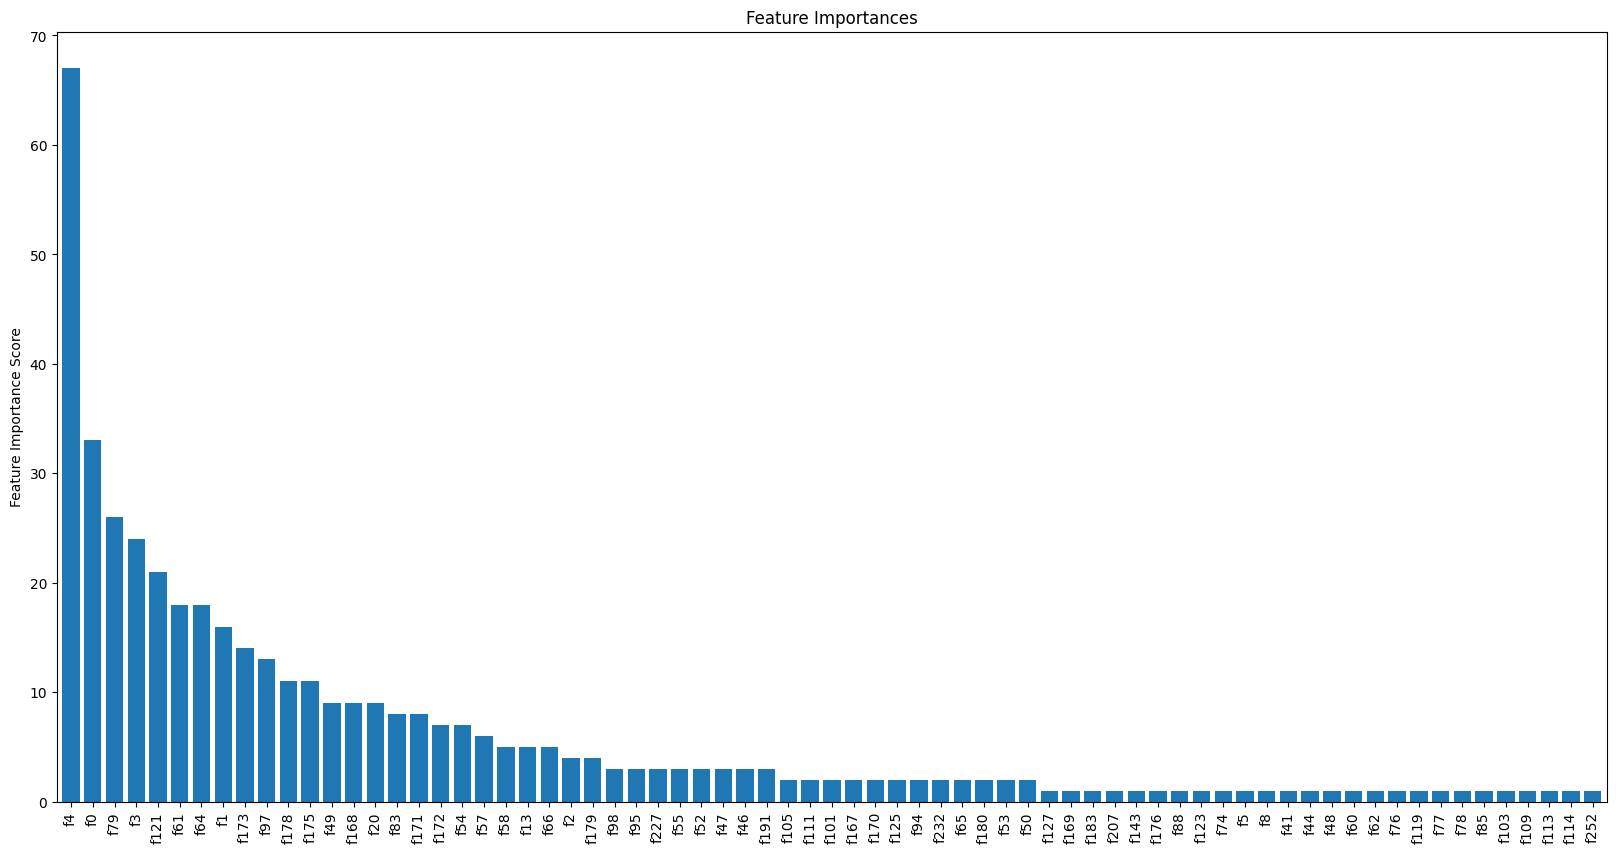

In [271]:
trainXGBBoostingClassifier(X, y, max_depth=3, gamma=0.7, print_accuracy=True, print_importance=True)
trainXGBBoostingClassifier(X_random, y, max_depth=3, gamma=0.7, print_accuracy=True)

In [163]:
def plotCapacityGraphsForRandomForest(X, y, filename, max_depth):
    gamma = 0
    createPlotDir('random_forest')

    data = dict()
    for depth in range(1, max_depth+1):
        print(f"{(depth/max_depth)*100:.2f}%...", end="\r")
        (empirical_loss, test_loss) = trainRandomForestClassifier(X, y, max_depth=depth)
        data[depth] = (empirical_loss, test_loss)
   
    savePlot(data, 'random_forest', filename)

max_depth = 20
plotCapacityGraphsForRandomForest(X, y, "x", max_depth)
plotCapacityGraphsForRandomForest(X_questions, y, "x_questions", max_depth)
plotCapacityGraphsForRandomForest(X_drugs, y, "x_drugs", max_depth)
plotCapacityGraphsForRandomForest(X_random, y, "x_random", max_depth)

<Figure size 640x480 with 0 Axes>

In [166]:
trainRandomForestClassifier(X, y, max_depth=3, print_accuracy=True)
trainRandomForestClassifier(X_random, y, max_depth=3, print_accuracy=True)

empirical_accuracy:  80.87% | test_accuracy:  62.82% 
empirical_accuracy:  71.45% | test_accuracy:  49.20% 


(10.290461363175678, 18.308660572880378)